## MultiModel with Decoders

### Image Captioning with ViT + GPT-2

In [ ]:
import IPython
from transformers import pipeline
from PIL import Image

img_files = ["paint-cat", "rock-head", "tree-frog", "two-jelly"]
images = [Image.open(f"img-files/{name}.jpg") for name in img_files]    

# vit-gpt2 pipeline 설정 
# Hugging Face에서 제공하는 Pre-trained 모델 활용 
vit_pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device = 'cuda')
for name, image in zip(img_files, images):
    print(f"{name}: {vit_pipe(image)}")
print()


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

paint-cat: [{'generated_text': 'a cat with a purple and green eyes '}]
rock-head: [{'generated_text': 'a statue of a bird on a white surface '}]
tree-frog: [{'generated_text': 'a small yellow and black bird sitting on a plant '}]
two-jelly: [{'generated_text': 'a black and white photo of a blue and white kite '}]



In [ ]:
starter_phrase = "I love"
starter_tokens = vit_pipe.tokenizer([starter_phrase] * len(images), return_tensors=vit_pipe.framework)
image_embeddings = vit_pipe.image_processor(images, return_tensors=vit_pipe.framework)
print("Start Inputs:", {k:getattr(v.to('cuda'), "shape", v.to('cuda')) for k,v in starter_tokens.items()})
print("Image Inputs:", {k:getattr(v.to('cuda'), "shape", v.to('cuda')) for k,v in image_embeddings.items()})

Start Inputs: {'input_ids': torch.Size([4, 2]), 'attention_mask': torch.Size([4, 2])}
Image Inputs: {'pixel_values': torch.Size([4, 3, 224, 224])}


In [16]:
type(starter_tokens)

transformers.tokenization_utils_base.BatchEncoding

In [17]:
type(image_embeddings)

transformers.image_processing_base.BatchFeature

## Diffusion Decoders

### 1. VAE(Variational Autoencoder)

VAE는 이미지를 압축(인코딩)하고 복원(디코딩)하는 생성 모델이다. 

- 인코더: 입력 이미지를 받아서 잠재공간(latent space)에 있는 **평균**과 **분산** 벡터로 압축하는데, 단순히 하나의 벡터값으로 압축하는 것이 아닌, **데이터 분포(distribution)**를 학습한다는 점이 핵심적인 특징이다. 
- 잠재공간: VAE의 잠재공간은 단순한 점이 아니라, 특정 확률 분포를 따르는 공간으로 이 공간에서 이미지를 복원하기 위한 정보를 추출한다. 
- 재매개변수화 트릭(Reparameterization Trick): 인코더가 학습한 평균과 분산으로부터 샘플링을 수행할 때, 모델의 역전파(backpropagation)가 가능하도록 하는 기법이다. 이 트릭을 통해 확률적 과정이 미분 가능한 연산으로 바뀌어 학습이 원활해진다. 
- 디코더: 잠재 공간에서 샘플링된 벡터를 입력으로 받아 원본 이미지와 유사한 이미지를 생성한다. 데이터의 분포를 학습하므로 잠재 공간의 특정 지점뿐만 아니라, 주변 영역에서도 의미 있는 새로운 이미지 생성 가능하다. 

VAE는 재구성 손실과 KL 발산을 최소화하는 방향으로 학습하는데, 먼저 재구성 손실(Reconstruction Loss)은 디코더가 생성한 이미지가 원본 이미지와 얼마나 유사한지 측정하는 것이다. kL 발산(KL Divergence)는 인코더가 출력한 잠재 공간의 분포가 표준 정규 분포와 얼마나 다른지를 측정해서 잠재 공간을 부드럽게 만든 후 의미 있는 새로운 이미지를 생성할 수 있게 한다. 
___

### 2. Diffusion model

Diffusion model은 점진적으로 노이즈를 제거하여 깨끗한 이미지를 생성하는 생성 모델이다. 노이즈를 제거하는 방식을 학습하기 위해서는 노이즈가 없는 깨끗한 이미지에서 출발해서 노이즈가 있는 이미지로 만드는 과정이 필요하다. 

- **순방향 확산 과정 (Forward Diffusion Process)**: 원본 이미지에 점진적으로 가우시안 노이즈를 추가하여 이미지를 완전히 노이즈로 만든다. 이 과정은 미리 정해진 스케줄에 따라 진행된다. 
    - 가우시안 노이즈를 더하는 이유: 이미지는 보통 복잡한 데이터 분포를 갖고 있다. 순방향 확산 과정동안 가우시안 노이즈를 점진적으로 더해서 마지막 단계에서는 이미지 데이터 분포를 **가우시안 분포**에 가깝게 만들기 위함이다. -> **중심 극한 정리**

- **역방향 확산 과정(Reverse Diffusion Process)**: 노이즈가 추가된 이미지에서 노이즈를 제거하여 깨끗한 이미지를 복원하는 과정이다. U-Net 같은 딥러닝 모델을 활용하며, 매 단계마다 노이즈를 예측하고 제거한다. 이 노이즈 제거 과정이 바로 **모델이 학습하는 부분**이다.
    - **Noise Schedule**: 각 단계(t)에서 얼마나 많은 노이즈를 추가할지 결정하는 규칙을 의미한다. Beta(t)값의 배열로 표현되는데, 이 값은 노이즈의 강도를 결정하는 분산 (varience) 매개변수이다. t = 1부터 T까지 증가하는 값으로 설정되며, t가 커질수록 더 많은 노이즈가 추가되어 원본 이미지가 더 빠르게 파괴된다. 

즉 모델은 특정 시간 단계(t)의 노이즈가 포함된 이미지 X(t)를 받아, 추가된 노이즈(e)를 예측하도록 학습한다. 추론 단계에서는 완전히 무작위의 노이즈 이미지에서 시작하여, 노이즈 제거 과정을 수십 수백 번 반복하며 점차적으로 깨끗한 이미지를 생성한다. 

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]
images.show()

c:\Users\user\anaconda3\envs\torchenv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--stabilityai--stable-diffusion-xl-base-1.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]Xet Storage is enabled for this re

In [33]:
prompt = "Robert Pattinson, actor of The Batman, rides the Batpod in the dark of night."
images = pipe(prompt=prompt).images[0]
images.show()

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


### Stable Diffusion 

이미지를 **latent(압축된 벡터 공간)** 에서 생성하는 딥러닝 기반 모델로, prompt를 바탕으로 noise에서 점점 원본 이미지로 복원하는 구조이다. 

In [34]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt

def decode_latents(self, latents):
    ## Borrowed from source: https://github.com/huggingface/diffusers/blob/e2ead7cdcc00859533e6bec7b0707a6fb0efef0a/src/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py#L1252
    ## This is a class method of the pipeline, so just pass in the pipeline for `self` and it should largely work.
    
    # upcasting: float16인 경우 메모리 사용은 줄지만 정밀도가 낮아 연산 과정에서 오류 발생 O
    # 따라서 vae.dtype이 float16인 경우 upcasting 
    needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
    if needs_upcasting:
        self.upcast_vae()
        # 잠재 데이터 latents의 데이터 타입 또한 vae 모델의 데이터타입과 동일하게 변환 
        latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
    elif latents.dtype != self.vae.dtype and torch.backends.mps.is_available():
        self.vae = self.vae.to(latents.dtype)
    # vae 설정에 latents_mean과 latents_std가 정의되어있는지 확인 -> 이는 latent space 데이터 정규화에 사용 
    has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
    has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
    if has_latents_mean and has_latents_std:
        latents_stat_fn = lambda conf_stat: torch.tensor(conf_stat).view(1, 4, 1, 1).to(latents.device, latents.dtype)
        latents_mean = latents_stat_fn(self.vae.config.latents_mean)
        latents_std = latents_stat_fn(self.vae.config.latents_std)
        latent_scale = latents_std / self.vae.config.scaling_factor + latents_mean
    else:
        latent_scale = 1 / self.vae.config.scaling_factor

    ## vae를 통해 decoding하여 원본 이미지로 복원 -> Denoising
    image = self.vae.decode(latents * latent_scale, return_dict=False)[0]

    ## CLEANUP AND RETURN
    if needs_upcasting:
        self.vae.to(dtype=torch.float16)
    return image

# Define a list to hold the images at each step
step_images = []
    
# Define a callback function to save images at each step
def save_step_image(pipeline, step, timestep, callback_kwargs):
    latents = callback_kwargs['latents']
    image = decode_latents(pipeline, latents)
    step_images.append(image)
    return callback_kwargs


100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


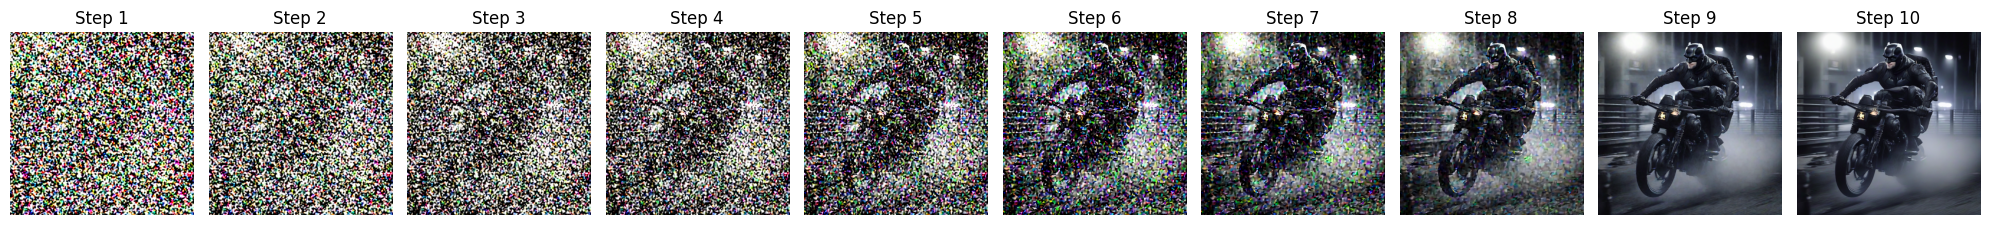

In [35]:
prompt = "Robert Pattinson, actor of The Batman, rides the Batpod in the dark of night."

# Run the pipeline with the callback function
pipe(
    prompt=prompt,
    num_inference_steps=10,  # Reduced for quicker visualization
    guidance_scale=7.5,
    callback_on_step_end=save_step_image,
    callback_on_step_end_tensor_inputs=['latents'],
    output_type='latent'  # So that we can decode latents ourselves
)

# Visualize the denoising steps
fig, axes = plt.subplots(1, len(step_images), figsize=(20, 5))
for i, img in enumerate(step_images):
    axes[i].imshow((img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
    axes[i].set_title(f"Step {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()